In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA


## Setting Up the Computation

In [2]:
np.random.seed(12345)
# we of course set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Now we want to access the training & testing data provided to us via a Stormer-Verlet integrator

In [4]:
x_train = np.loadtxt('train.txt')
y_train=x_train[1:len(x_train)]
x_train=x_train[0:len(x_train)-1]
# we have prepared the training data for the neural network

In [5]:

# we are changing the function to find the period for non-closed orbits
def find_period(x):
    period=0
    p=x[:,0]
    theta=x[:,1]
    initial=np.array([p[0], theta[0]])
    D=1.0
    for i,v in enumerate(theta):
        if i>10:
            distance=LA.norm(np.array([p[i], theta[i]])- initial)
            if distance<D:
                D=distance
                period=0.1*i
    return period

In [6]:
# this is basically a typical tanh activation function neural network, we took the code from class
class FNN(nn.Module):
    # we will use a tanh activation function
    def __init__(self, input_dim, hidden_layers, num_neurons, output_dim):
        super(FNN, self).__init__()
        self.net = nn.Sequential()
        self.net.add_module("lin_layer_0", nn.Linear(input_dim,num_neurons))
        self.net.add_module("tanh_layer_0", nn.Tanh())

        for num in range(1, hidden_layers+1):
            self.net.add_module("lin_layer_%d" %(num), nn.Linear(num_neurons, num_neurons))
            self.net.add_module("tanh_layer_%d", nn.Tanh())

        self.net.add_module("lin_layer_output", nn.Linear(num_neurons, output_dim))
        
    def forward(self, x):
        return self.net(x)


We first define the FNN class, and now we are ready to actually train the network.

In [8]:
# we now train the network to predict the output, optimizer step was 1e-3, 
def train_network(x_train, y_train, N, L, N_iter):
    N_i = 2  # input dimension, just the momentum and angle
    N_o = 2  # output dimension, momentum and angle

    # Create FNN
    net = FNN(N_i, L, N, N_o)

    inputs = torch.from_numpy(x_train).float()
    outputs = torch.from_numpy(y_train).float()

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    #the optimizer step will be three orders of magnitude below the typical order of magnitude in the problem
    loss_func = torch.nn.MSELoss()
    # mean square error loss function
    for n in range(N_iter):
        prediction = net(inputs)
        loss = loss_func(prediction, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return net

## Training the FNN

Now we also know how to train the network, and we are pretty much ready to apply the FNN to the pendulum problem.

In [16]:
N=30
L=3
N_iter=50000
# We have set the depth of the network to be 3 and its width to be 30, with 50000 epochs. This is a standard architecture for a successfull FNN
net=train_network(x_train, y_train, N, L, N_iter)
print('done')

done


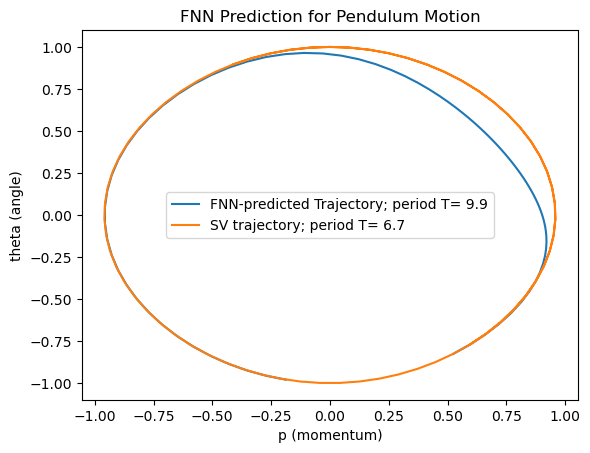

In [19]:
# this is a function that finds a temporal shift of the trajectory with respect to the correct trajectory
def find_shift(trajectory, y_test, i, h):
    k=0
    f=trajectory[i]
    norm=LA.norm(y_test[0]-f)
    for j in range(max(i-10, 0),i):
        if LA.norm(y_test[j]- f)< norm:
            k=j
            norm=LA.norm(y_test[j]-f)
    return np.abs(k-i)*h
#training the network from the textual file
x_test=np.loadtxt('test.txt')
y_test=x_test[1:len(x_test)]
x_test=x_test[0:len(x_test)-1]

# we have now prepared the data for testing, so let us just turn it into a Torch tensor
x_test=torch.from_numpy(x_test).float()
trajectory=[x_test[0,:].detach().numpy()]
time=[]
h=0.1 # given in the problem
for i in range(1,100):
    time.append(i*h)
MSE=[]
temporal_shifts=[]
energy_correct=[]
energy_predicted=[]
previous=x_test[0,:]
for i in range(1,100):
    new_point=net(previous)
    previous=new_point
    new_point=new_point.detach().numpy()
    mse=LA.norm((new_point - y_test[i-1]))
    energy=0.5* (new_point[0]**2) - np.cos(new_point[1]) 
    energy_predicted.append(energy)
    enery=0.5 * (y_test[i-1][0]**2) - np.cos(y_test[i-1][1])
    energy_correct.append(enery)
    MSE.append(mse)
    trajectory.append(new_point)
    temporal_shifts.append(find_shift(trajectory, y_test, i, h) )
trajectory=np.array(trajectory)

# we just plot the results now
plt.plot(trajectory[:,0], trajectory[:,1], label='FNN-predicted Trajectory; period T= '+ str(find_period(trajectory)))
plt.plot(y_test[:,0], y_test[:,1], label='SV trajectory; period T= '+ str(find_period(y_test)))
plt.xlabel('p (momentum)')
plt.ylabel('theta (angle)')
plt.title('FNN Prediction for Pendulum Motion')
plt.legend()
plt.savefig('fnn.png')
plt.show()

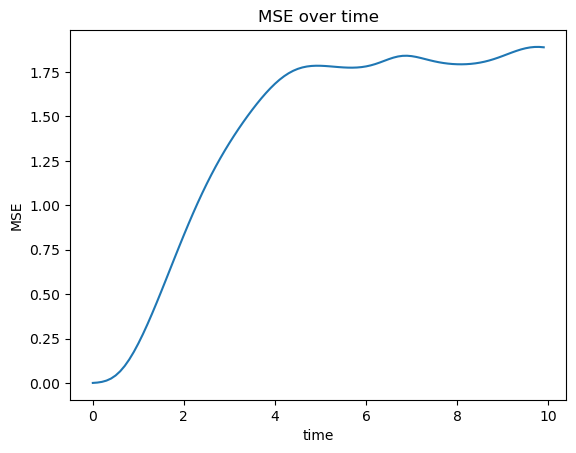

In [21]:
time=[0.0]+time
MSE=[0.0]+MSE
plt.plot(time, MSE)
plt.xlabel('time')
plt.ylabel('MSE')
plt.title('MSE over time')
plt.savefig('fnn_mse.png')
plt.show()

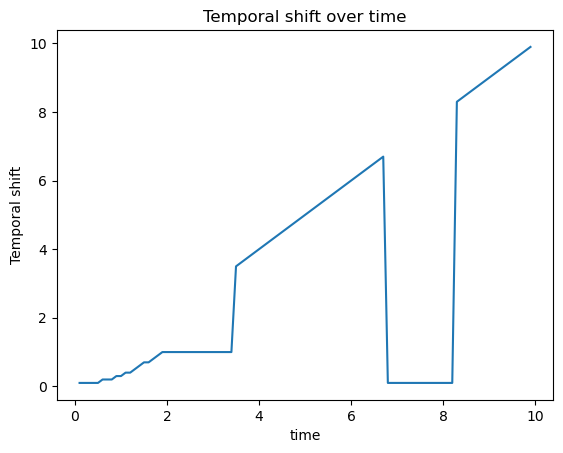

In [23]:
plt.plot(time[1:],temporal_shifts)
plt.xlabel('time')
plt.ylabel('Temporal shift')
plt.title('Temporal shift over time')
plt.savefig('fnn_shift.png')
plt.show()

So we need something better actually. Let us try to work with a SympNet now.

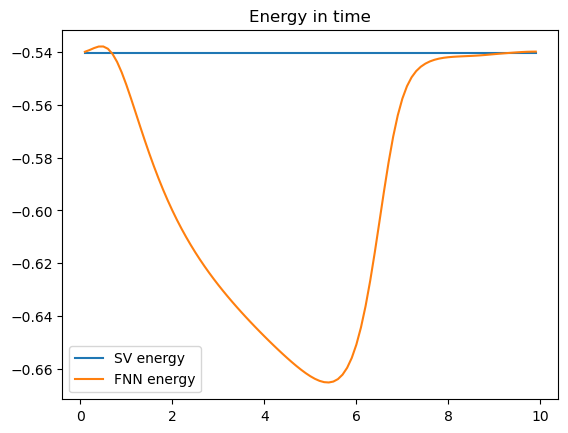

In [25]:
plt.plot(time[1:], energy_correct, label='SV energy')
plt.plot(time[1:], energy_predicted, label='FNN energy')
plt.title('Energy in time')
plt.legend()
plt.savefig('fnn_energy.png')
plt.show()

## Training the SympNets (G-SympNet and LA-SympNet)

In [27]:
# This is just the code provided by the 

"""
@author: jpzxshi
"""
import abc
import torch

class Module(torch.nn.Module):
    '''Standard module format. 
    '''
    def __init__(self):
        super(Module, self).__init__()
        self.activation = None
        self.initializer = None
        
        self.__device = None
        self.__dtype = None
        
    @property
    def device(self):
        return self.__device
        
    @property
    def dtype(self):
        return self.__dtype

    @device.setter
    def device(self, d):
        if d == 'cpu':
            self.cpu()
        elif d == 'gpu':
            self.cuda()
        else:
            raise ValueError
        self.__device = d
    
    @dtype.setter    
    def dtype(self, d):
        if d == 'float':
            self.to(torch.float)
        elif d == 'double':
            self.to(torch.double)
        else:
            raise ValueError
        self.__dtype = d

    @property
    def Device(self):
        if self.__device == 'cpu':
            return torch.device('cpu')
        elif self.__device == 'gpu':
            return torch.device('cuda')
        
    @property
    def Dtype(self):
        if self.__dtype == 'float':
            return torch.float32
        elif self.__dtype == 'double':
            return torch.float64

    @property
    def act(self):
        if self.activation == 'sigmoid':
            return torch.sigmoid
        elif self.activation == 'relu':
            return torch.relu
        elif self.activation == 'tanh':
            return torch.tanh
        elif self.activation == 'elu':
            return torch.elu
        else:
            raise NotImplementedError
    
    @property        
    def Act(self):
        if self.activation == 'sigmoid':
            return torch.nn.Sigmoid()
        elif self.activation == 'relu':
            return torch.nn.ReLU()
        elif self.activation == 'tanh':
            return torch.nn.Tanh()
        elif self.activation == 'elu':
            return torch.nn.ELU()
        else:
            raise NotImplementedError

    @property
    def weight_init_(self):
        if self.initializer == 'He normal':
            return torch.nn.init.kaiming_normal_
        elif self.initializer == 'He uniform':
            return torch.nn.init.kaiming_uniform_
        elif self.initializer == 'Glorot normal':
            return torch.nn.init.xavier_normal_
        elif self.initializer == 'Glorot uniform':
            return torch.nn.init.xavier_uniform_
        elif self.initializer == 'orthogonal':
            return torch.nn.init.orthogonal_
        elif self.initializer == 'default':
            if self.activation == 'relu':
                return torch.nn.init.kaiming_normal_
            elif self.activation == 'tanh':
                return torch.nn.init.orthogonal_
            else:
                return lambda x: None
        else:
            raise NotImplementedError
            
class StructureNN(Module):
    '''Structure-oriented neural network used as a general map based on designing architecture.
    '''
    def __init__(self):
        super(StructureNN, self).__init__()
        
    def predict(self, x, returnnp=False):
        return self(x).cpu().detach().numpy() if returnnp else self(x)
    
class LossNN(Module, abc.ABC):
    '''Loss-oriented neural network used as an algorithm based on designing loss.
    '''
    def __init__(self):
        super(LossNN, self).__init__()
        
    #@final
    def forward(self, x):
        return x
    
    @abc.abstractmethod
    def criterion(self, X, y):
        pass
    
    @abc.abstractmethod
    def predict(self):
        pass

In [29]:
# Ok so this is just the code the Professor and the TA provided on the GitHub page of the course

"""
@author: jpzxshi
"""
import torch
import torch.nn as nn



class LinearModule(Module):
    '''Linear symplectic module.
    '''
    def __init__(self, dim, layers):
        super(LinearModule, self).__init__()
        self.dim = dim
        self.layers = layers
        
        self.params = self.__init_params()
        
    def forward(self, pqh):
        p, q, h = pqh[0], pqh[1], pqh[2]
        for i in range(self.layers):
            S = self.params['S{}'.format(i + 1)]
            if i % 2 == 0:
                p = p + q @ (S + S.t()) * h
            else:
                q = p @ (S + S.t()) * h + q
        return p + self.params['bp'] * h, q + self.params['bq'] * h
    
    def __init_params(self):
        '''Si is distributed N(0, 0.01), and b is set to zero.
        '''
        d = int(self.dim / 2)
        params = nn.ParameterDict()
        for i in range(self.layers):
            params['S{}'.format(i + 1)] = nn.Parameter((torch.randn([d, d]) * 0.01).requires_grad_(True))
        params['bp'] = nn.Parameter(torch.zeros([d]).requires_grad_(True))
        params['bq'] = nn.Parameter(torch.zeros([d]).requires_grad_(True))
        return params
        
class ActivationModule(Module):
    '''Activation symplectic module.
    '''
    def __init__(self, dim, activation, mode):
        super(ActivationModule, self).__init__()
        self.dim = dim
        self.activation = activation
        self.mode = mode
        
        self.params = self.__init_params()
        
    def forward(self, pqh):
        p, q, h = pqh[0], pqh[1], pqh[2]
        if self.mode == 'up':
            return p + self.act(q) * self.params['a'] * h, q
        elif self.mode == 'low':
            return p, self.act(p) * self.params['a'] * h + q
        else:
            raise ValueError
            
    def __init_params(self):
        d = int(self.dim / 2)
        params = nn.ParameterDict()
        params['a'] = nn.Parameter((torch.randn([d]) * 0.01).requires_grad_(True))
        return params
            
class GradientModule(Module):
    '''Gradient symplectic module.
    '''
    def __init__(self, dim, width, activation, mode):
        super(GradientModule, self).__init__()
        self.dim = dim
        self.width = width
        self.activation = activation
        self.mode = mode
        
        self.params = self.__init_params()
        
    def forward(self, pqh):
        p, q, h = pqh[0], pqh[1], pqh[2]
        if self.mode == 'up':
            gradH = (self.act(q @ self.params['K'] + self.params['b']) * self.params['a']) @ self.params['K'].t()
            return p + gradH * h, q
        elif self.mode == 'low':
            gradH = (self.act(p @ self.params['K'] + self.params['b']) * self.params['a']) @ self.params['K'].t()
            return p, gradH * h + q
        else:
            raise ValueError
            
    def __init_params(self):
        d = int(self.dim / 2)
        params = nn.ParameterDict()
        params['K'] = nn.Parameter((torch.randn([d, self.width]) * 0.01).requires_grad_(True))
        params['a'] = nn.Parameter((torch.randn([self.width]) * 0.01).requires_grad_(True))
        params['b'] = nn.Parameter(torch.zeros([self.width]).requires_grad_(True))
        return params
    
class SympNet(StructureNN):
    def __init__(self):
        super(SympNet, self).__init__()
        self.dim = None
        
    def predict(self, xh, steps=1, keepinitx=False, returnnp=False):
        dim = xh.size(-1)
        size = len(xh.size())
        if dim == self.dim:
            pred = [xh]
            for _ in range(steps):
                pred.append(self(pred[-1]))
        else:
            x0, h = xh[..., :-1], xh[..., -1:] 
            pred = [x0]
            for _ in range(steps):
                pred.append(self(torch.cat([pred[-1], h], dim=-1)))
        if keepinitx:
            steps = steps + 1
        else:
            pred = pred[1:]
        res = torch.cat(pred, dim=-1).view([-1, steps, self.dim][2 - size:])
        return res.cpu().detach().numpy() if returnnp else res

class LASympNet(SympNet):
    '''LA-SympNet.
    Input: [num, dim] or [num, dim + 1]
    Output: [num, dim]
    '''
    def __init__(self, dim, layers=3, sublayers=2, activation='sigmoid'):
        super(LASympNet, self).__init__()
        self.dim = dim
        self.layers = layers
        self.sublayers = sublayers
        self.activation = activation
        
        self.modus = self.__init_modules()
        
    def forward(self, pqh):
        d = int(self.dim / 2)
        if pqh.size(-1) == self.dim + 1:
            p, q, h = pqh[..., :d], pqh[..., d:-1], pqh[..., -1:]
        elif pqh.size(-1) == self.dim:
            p, q, h = pqh[..., :d], pqh[..., d:], torch.ones_like(pqh[..., -1:])
        else:
            raise ValueError
        for i in range(self.layers - 1):
            LinM = self.modus['LinM{}'.format(i + 1)]
            ActM = self.modus['ActM{}'.format(i + 1)]
            p, q = ActM([*LinM([p, q, h]), h])
        return torch.cat(self.modus['LinMout']([p, q, h]), dim=-1)
    
    def __init_modules(self):
        modules = nn.ModuleDict()
        for i in range(self.layers - 1):
            modules['LinM{}'.format(i + 1)] = LinearModule(self.dim, self.sublayers)
            mode = 'up' if i % 2 == 0 else 'low'
            modules['ActM{}'.format(i + 1)] = ActivationModule(self.dim, self.activation, mode)
        modules['LinMout'] = LinearModule(self.dim, self.sublayers)
        return modules

class GSympNet(SympNet):
    '''G-SympNet.
    Input: [num, dim] or [num, dim + 1]
    Output: [num, dim]
    '''
    def __init__(self, dim, layers=3, width=20, activation='sigmoid'):
        super(GSympNet, self).__init__()
        self.dim = dim
        self.layers = layers
        self.width = width
        self.activation = activation
        
        self.modus = self.__init_modules()
        
    def forward(self, pqh):
        d = int(self.dim / 2)
        if pqh.size(-1) == self.dim + 1:
            p, q, h = pqh[..., :d], pqh[..., d:-1], pqh[..., -1:]
        elif pqh.size(-1) == self.dim:
            p, q, h = pqh[..., :d], pqh[..., d:], torch.ones_like(pqh[..., -1:])
        else:
            raise ValueError
        for i in range(self.layers):
            GradM = self.modus['GradM{}'.format(i + 1)]
            p, q = GradM([p, q, h])
        return torch.cat([p, q], dim=-1)
    
    def __init_modules(self):
        modules = nn.ModuleDict()
        for i in range(self.layers):
            mode = 'up' if i % 2 == 0 else 'low'
            modules['GradM{}'.format(i + 1)] = GradientModule(self.dim, self.width, self.activation, mode)
        return modules

In [31]:
# we now train the network to predict the output, optimizer step was 1e-3
# We first train a G-SympNet
def train_symp_network(x_train, y_train, N, L, N_iter):
    N_i = 2  # input dimension, just the momentum and angle
    N_o = 2  # output dimension, momentum and angle

    # Create FNN
    dim=2 # \p, \theta
    net = GSympNet(dim=dim, layers=L, width = N, activation='tanh')

    inputs = torch.from_numpy(x_train).float()
    outputs = torch.from_numpy(y_train).float()

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    #the optimizer step will be three orders of magnitude below the typical order of magnitude in the problem
    loss_func = torch.nn.MSELoss()
    # mean square error loss function
    for n in range(N_iter):
        prediction = net(inputs)
        loss = loss_func(prediction, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return net
# We now train an LA-SympNet
def train_LA_symp_network(x_train, y_train, N, S, N_iter):
    N_i = 2  # input dimension, just the momentum and angle
    N_o = 2  # output dimension, momentum and angle

    # Create FNN
    dim=2 # \p, \theta
    net = LASympNet(dim=dim, layers=L, sublayers = S, activation='tanh')

    inputs = torch.from_numpy(x_train).float()
    outputs = torch.from_numpy(y_train).float()

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
    #the optimizer step will be three orders of magnitude below the typical order of magnitude in the problem
    loss_func = torch.nn.MSELoss()
    # mean square error loss function
    for n in range(N_iter):
        prediction = net(inputs)
        loss = loss_func(prediction, outputs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return net

In [33]:
N=30
L=3
N_iter=50000
# We will first train a G-SympNet
symp_net=train_symp_network(x_train, y_train, N, L, N_iter)
print('done')

done


In [35]:
# We will now train an LA-SympNet
N=30
S=3
N_iter=50000
LA_symp_net=train_LA_symp_network(x_train, y_train, N, S, N_iter)
print('done')

done


In [37]:
np.random.seed(123456)
# we are changing the function to find the period for non-closed orbits
def find_period(x):
    period=0
    p=x[:,0]
    theta=x[:,1]
    initial=np.array([p[0], theta[0]])
    D=1.0
    for i,v in enumerate(theta):
        if i>10:
            distance=LA.norm(np.array([p[i], theta[i]])- initial)
            if distance<D:
                D=distance
                period=0.1*i
    return period

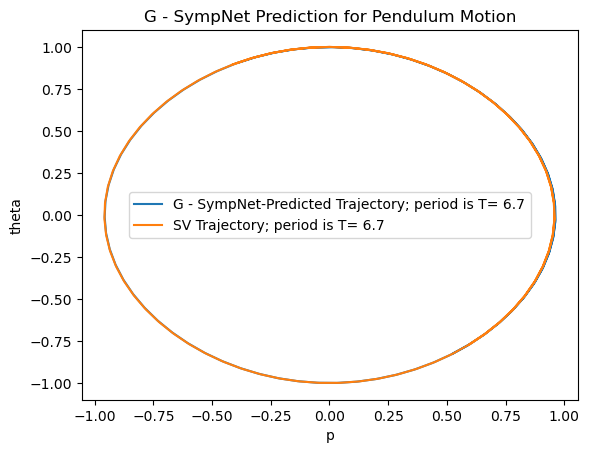

In [269]:
MSE_symp=[]
temporal_shifts_symp=[]
energy_correct_symp=[]
energy_predicted_symp=[]
previous=x_test[0,:]
trajectory_symp=[x_test[0,:].detach().numpy()]
for i in range(1,100):
    new_point=symp_net(previous)
    previous=new_point
    new_point=new_point.detach().numpy()
    mse=LA.norm((new_point - y_test[i-1]))
    energy_symp=0.5* (new_point[0]**2) - np.cos(new_point[1]) 
    energy_predicted_symp.append(energy_symp)
    enery=0.5 * (y_test[i-1][0]**2) - np.cos(y_test[i-1][1])
    energy_correct_symp.append(enery)
    MSE_symp.append(mse)
    trajectory_symp.append(new_point)
    temporal_shifts_symp.append(find_shift(trajectory_symp, y_test, i, h) )
trajectory_symp=np.array(trajectory_symp)

# we just plot the results now
plt.plot(trajectory_symp[:,0], trajectory_symp[:,1], label='G - SympNet-Predicted Trajectory; period is T= '+ str(find_period(trajectory_symp)))
plt.plot(y_test[:,0], y_test[:,1], label='SV Trajectory; period is T= ' +str(find_period(y_test)))
plt.xlabel('p')
plt.ylabel('theta')
plt.title('G - SympNet Prediction for Pendulum Motion')
plt.legend()
plt.savefig('sympnet.png')
plt.show()

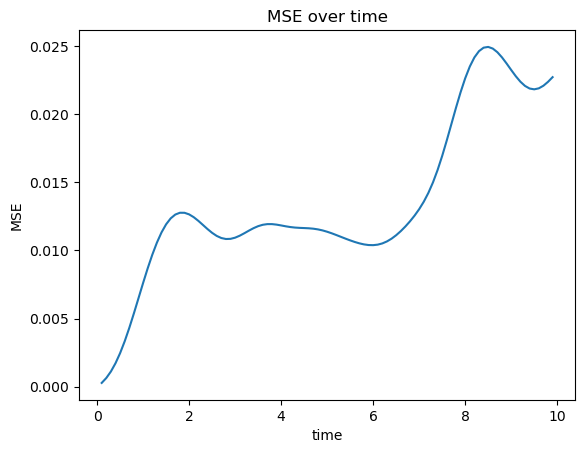

In [69]:
plt.plot(time[1:], MSE_symp)
plt.xlabel('time')
plt.ylabel('MSE')
plt.title('MSE over time')
plt.savefig('symp_mse.png')
plt.show()

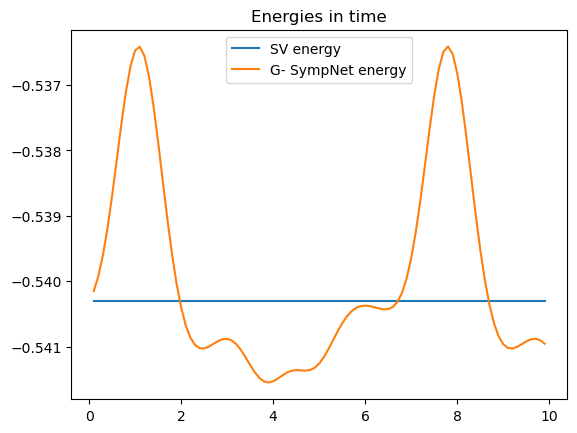

In [71]:
plt.plot(time[1:], energy_correct_symp, label='SV energy')
plt.plot(time[1:], energy_predicted_symp, label='G- SympNet energy')
plt.title('Energies in time')
plt.legend()
plt.savefig('symp_energy.png')
plt.show()

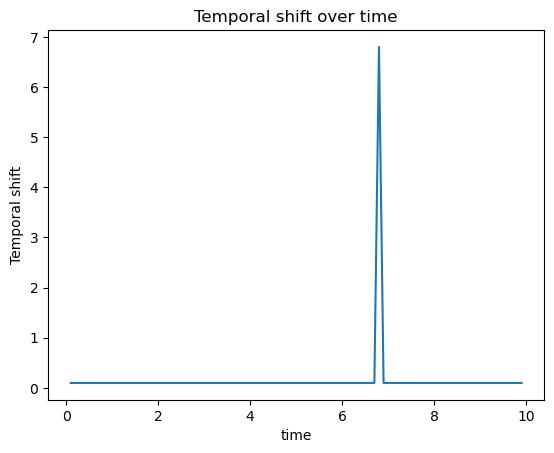

In [73]:
plt.plot(time[1:],temporal_shifts_symp)
plt.xlabel('time')
plt.ylabel('Temporal shift')
plt.title('Temporal shift over time')
plt.savefig('symp_shift.png')
plt.show()

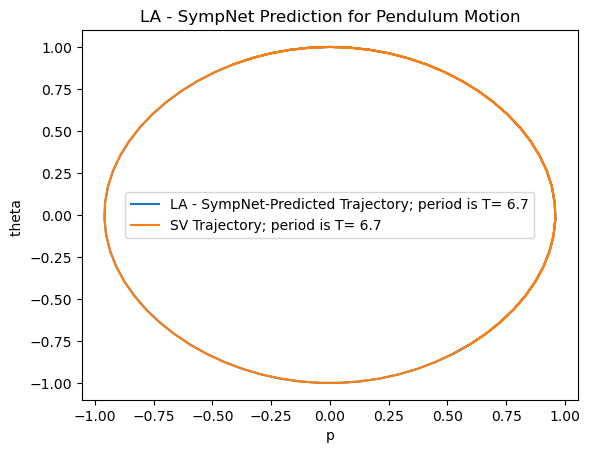

In [271]:
MSE_LA_symp = []
temporal_shifts_LA_symp = []
energy_correct_LA_symp = []
energy_predicted_LA_symp = []
previous = x_test[0, :]
trajectory_LA_symp = [x_test[0, :].detach().numpy()]
for i in range(1, 100):
    new_point = LA_symp_net(previous)
    previous = new_point
    new_point = new_point.detach().numpy()
    mse = LA.norm((new_point - y_test[i - 1]))
    energy_LA_symp = 0.5 * (new_point[0]**2) - np.cos(new_point[1])
    energy_predicted_LA_symp.append(energy_LA_symp)
    enery = 0.5 * (y_test[i - 1][0]**2) - np.cos(y_test[i - 1][1])
    energy_correct_LA_symp.append(enery)
    MSE_LA_symp.append(mse)
    trajectory_LA_symp.append(new_point)
    temporal_shifts_LA_symp.append(find_shift(trajectory_LA_symp, y_test, i, h))
trajectory_LA_symp = np.array(trajectory_LA_symp)

# we just plot the results now
plt.plot(trajectory_LA_symp[:, 0], trajectory_LA_symp[:, 1], label='LA - SympNet-Predicted Trajectory; period is T= ' + str(find_period(trajectory_LA_symp)))
plt.plot(y_test[:, 0], y_test[:, 1], label='SV Trajectory; period is T= ' + str(find_period(y_test)))
plt.xlabel('p')
plt.ylabel('theta ')
plt.title('LA - SympNet Prediction for Pendulum Motion')
plt.legend()
plt.savefig('LA_sympnet.png')
plt.show()


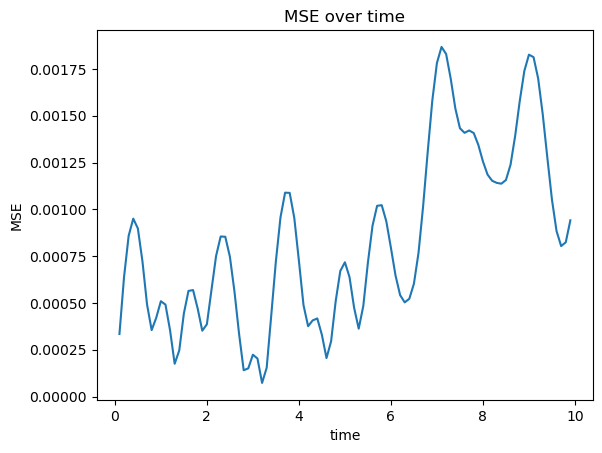

In [77]:
plt.plot(time[1:], MSE_LA_symp)
plt.xlabel('time')
plt.ylabel('MSE')
plt.title('MSE over time')
plt.savefig('LA_symp_mse.png')
plt.show()

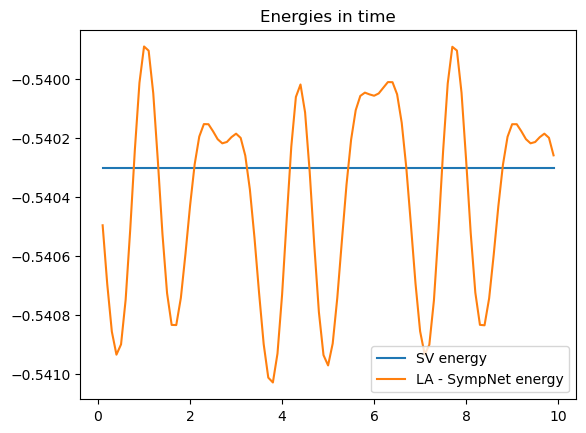

In [267]:
plt.plot(time[1:], energy_correct_symp, label='SV energy')
plt.plot(time[1:], energy_predicted_LA_symp, label='LA - SympNet energy')
plt.title('Energies in time')
plt.legend()
plt.savefig('LA_symp_energy.png')
plt.show()

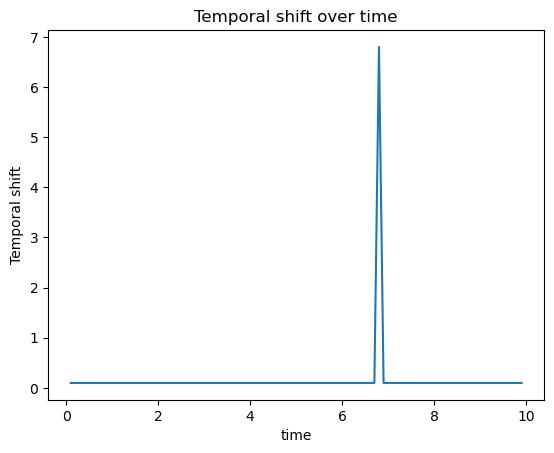

In [81]:
plt.plot(time[1:],temporal_shifts_LA_symp)
plt.xlabel('time')
plt.ylabel('Temporal shift')
plt.title('Temporal shift over time')
plt.savefig('LA_symp_shift.png')
plt.show()

## Training the PINN

In [211]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)


class PINNNN(nn.Module):
    # we will use a tanh activation function
    def __init__(self, input_dim, hidden_layers, num_neurons, output_dim):
        super(PINNNN, self).__init__()  
        self.net = nn.Sequential()
        self.net.add_module("lin_layer_0", nn.Linear(input_dim, num_neurons))
        self.net.add_module("tanh_layer_0", nn.Tanh())

        for num in range(1, hidden_layers + 1):
            self.net.add_module("lin_layer_%d" % (num), nn.Linear(num_neurons, num_neurons))
            self.net.add_module("tanh_layer_%d" % (num), nn.Tanh())

        self.net.add_module("lin_layer_output", nn.Linear(num_neurons, output_dim))
        
        # We set the parameters m and l to 1.2 and 0.8 initially
        self.m = nn.Parameter(torch.tensor(1.2))
        self.l = nn.Parameter(torch.tensor(0.8))
        self.g = 1.0  
        
        self.dt = 0.1  

    def forward(self, x_prev):
        return self.net(x_prev)
    # we define the physics loss here 
    def physics_loss(self, x_prev, x_next):
        
        p_x_prev, theta_prev = x_prev[:, 0], x_prev[:, 1]
        p_x_next, theta_next = x_next[:, 0], x_next[:, 1]
        
        dp_x_dt = (p_x_next - p_x_prev) / self.dt
        dtheta_dt = (theta_next - theta_prev) / self.dt
        
        dtheta_dt_phys = p_x_prev / (self.m * self.l**2)
        dp_x_dt_phys = -self.m * self.g * self.l * torch.sin(theta_prev)
        # now we just sum up these losses
        loss_theta = torch.mean((dtheta_dt - dtheta_dt_phys) ** 2)
        loss_p_x = torch.mean((dp_x_dt - dp_x_dt_phys) ** 2)
        # We now return the physics loss
        return loss_theta + loss_p_x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNNN(2, 3, 30, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
n_epochs = 50000


x_train, y_train = x_train.to(device), y_train.to(device)

# Training loop
for epoch in range(n_epochs):
    optimizer.zero_grad()
    # this is the data loss
    y_pred = model(x_train)
    data_loss = torch.mean((y_pred - y_train) ** 2)
    # this is the physics loss as above
    physics_loss = model.physics_loss(x_train, y_pred)
    # Total loss
    loss = data_loss + 0.1 * physics_loss  # Weighting physics loss at 0.1 (not equal weighting)
    loss.backward()
    optimizer.step()


/tmp/ipykernel_4664/3008324719.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_4664/3008324719.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


Learned m: 0.9955, l: 1.0016


## Learned parameters

In [213]:
print('Learned m is '+ str(model.m.item()))
print('Learned l is '+ str(model.l.item()))

Learned m is 0.9955234527587891
Learned l is 1.0016285181045532


In [215]:

# This is just a stormer-verlet algorithm from the learned parameters
def stormer_verlet(p0, theta0, m, l, h, steps):
    p_list = [p0]
    theta_list = [theta0]
    p = p0
    theta = theta0

    for w in range(steps):
        # now we are just simulating the physics
        p_1 = p - 0.5 * h * m * l * np.sin(theta)
        theta = theta + h * p_1 / (m * l**2)
        p = p_1 - 0.5 * h * m * l * np.sin(theta)

        p_list.append(p)
        theta_list.append(theta)

    return np.stack([p_list, theta_list], axis=1)

## The predicted trajectory

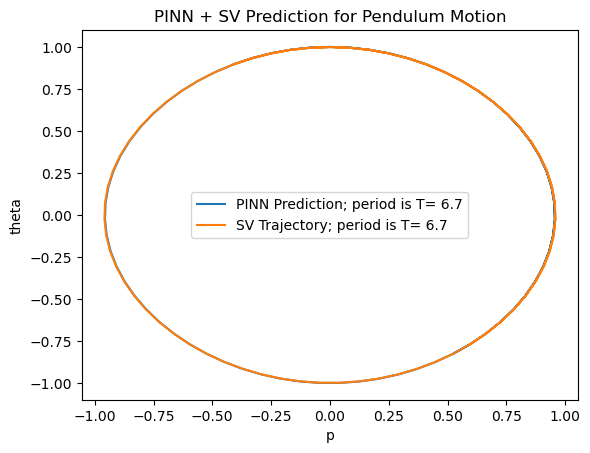

In [241]:
# Initial condition from train.txt last point
p0 = x_test[0, 0]
theta0=x_test[0, 1]

# Integrate using learned m, l
m_val = model.m.item()
l_val = model.l.item()

# we run the simulation
trajectory_PINN = stormer_verlet(p0, theta0, m_val, l_val, h=0.1, steps=99)
MSE_PINN=[]
temporal_shifts_PINN=[]
energy_correct_PINN=[]
energy_predicted_PINN=[]
previous=x_test[0,:]
for i in range(1,100):
    new_point=trajectory_PINN[i,:]
    mse=LA.norm((new_point - y_test[i-1]))
    energy_PINN=0.5* (new_point[0]**2) - np.cos(new_point[1]) 
    energy_predicted_PINN.append(energy_PINN)
    enery=0.5 * (y_test[i-1][0]**2) - np.cos(y_test[i-1][1])
    energy_correct_PINN.append(enery)
    MSE_PINN.append(mse)
    temporal_shifts_PINN.append(find_shift(trajectory_PINN, y_test, i, h) )


# we just plot the results now
plt.plot(trajectory_PINN[:,0], trajectory_PINN[:,1], label='PINN Prediction; period is T= '+str(find_period(trajectory_PINN)))
plt.plot(y_test[:,0], y_test[:,1], label='SV Trajectory; period is T= '+ str(find_period(y_test)))
plt.xlabel('p')
plt.ylabel('theta')
plt.title('PINN + SV Prediction for Pendulum Motion')
plt.legend()
plt.savefig('pinn.png')
plt.show()

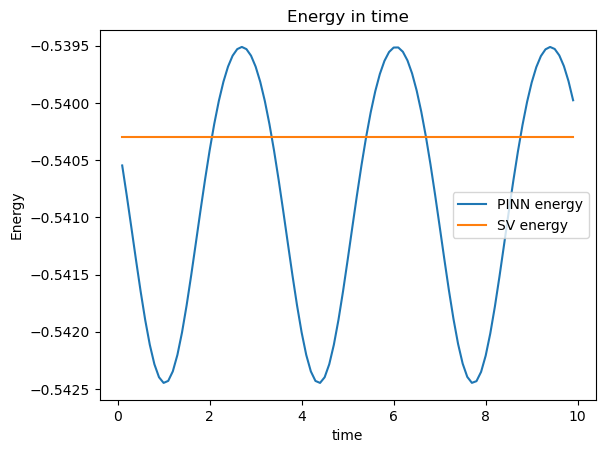

In [243]:
plt.plot(time[1:], energy_predicted_PINN, label='PINN energy')
plt.plot(time[1:], energy_correct_PINN, label='SV energy')
plt.xlabel('time')
plt.ylabel('Energy')
plt.title('Energy in time')
plt.legend()
plt.savefig('pinn_energy.png')
plt.show()

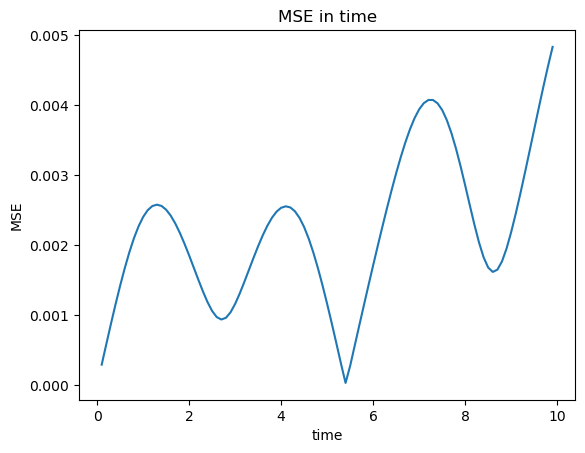

In [245]:
plt.plot(time[1:], MSE_PINN)
plt.xlabel('time')
plt.ylabel('MSE')
plt.title('MSE in time')
plt.savefig('pinn_mse.png')
plt.show()

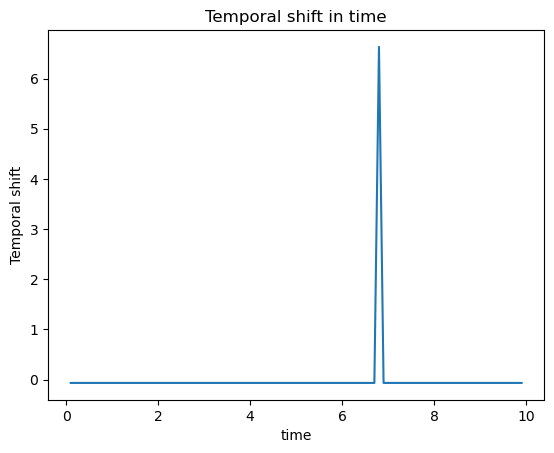

In [247]:
temporal_shifts_PINN=np.array(temporal_shifts_PINN)
temporal_shifts_PINN=temporal_shifts_PINN- temporal_shifts_PINN.mean()
plt.plot(time[1:],temporal_shifts_PINN)
plt.xlabel('time')
plt.ylabel('Temporal shift')
plt.title('Temporal shift in time')
plt.savefig('pinn_shift.png')
plt.show()

## Comparison of Various Modeling Assumptions and Results

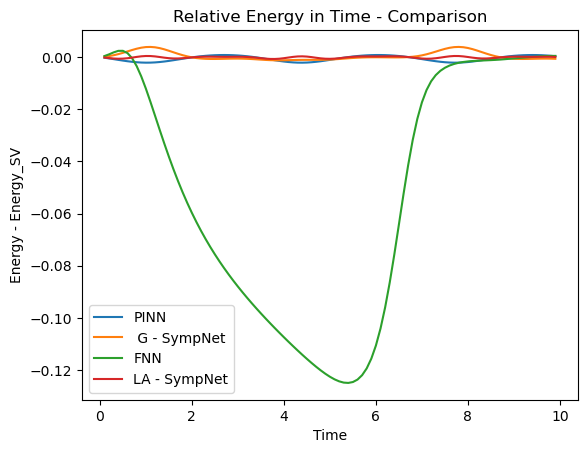

In [249]:
plt.plot(time[1:], np.array(energy_predicted_PINN)-np.array(energy_correct), label='PINN')
plt.plot(time[1:], np.array(energy_predicted_symp)-np.array(energy_correct), label=' G - SympNet')
plt.plot(time[1:], np.array(energy_predicted[0:])-np.array(energy_correct), label='FNN')
plt.plot(time[1:], np.array(energy_predicted_LA_symp[0:])-np.array(energy_correct), label='LA - SympNet')
plt.ylabel('Energy - Energy_SV')
plt.xlabel('Time')
plt.title('Relative Energy in Time - Comparison')
plt.legend()
plt.savefig('energy_comparison.png')


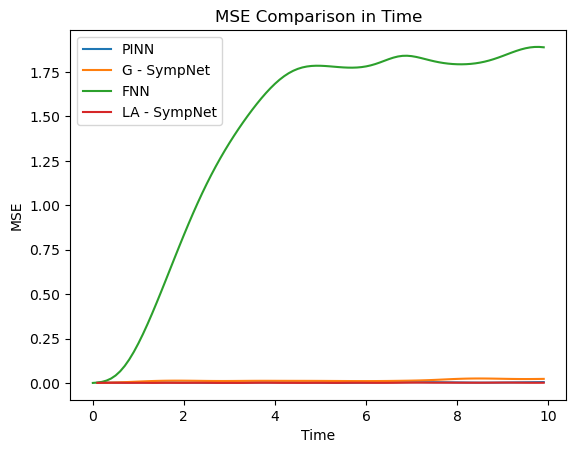

In [251]:
plt.plot(time[1:], MSE_PINN, label='PINN')
plt.plot(time[1:], MSE_symp, label='G - SympNet')
plt.plot(time[0:], MSE, label='FNN')
plt.plot(time[1:], MSE_LA_symp, label='LA - SympNet')
plt.ylabel('MSE')
plt.xlabel('Time')
plt.title('MSE Comparison in Time')
plt.legend()
plt.savefig('mse_comparison.png')
plt.show()

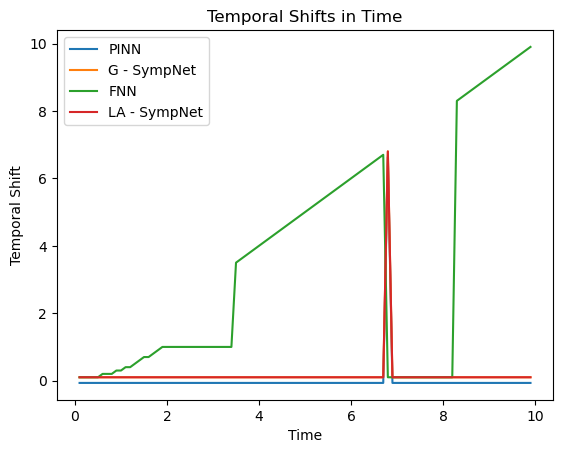

In [253]:
plt.plot(time[1:], temporal_shifts_PINN, label='PINN')
plt.plot(time[1:], temporal_shifts_symp, label='G - SympNet')
plt.plot(time[1:], temporal_shifts, label='FNN')
plt.plot(time[1:], temporal_shifts_LA_symp, label='LA - SympNet')
plt.xlabel('Time')
plt.ylabel('Temporal Shift')
plt.title('Temporal Shifts in Time')
plt.legend()
plt.savefig('temporal_comparison.png')
plt.show()

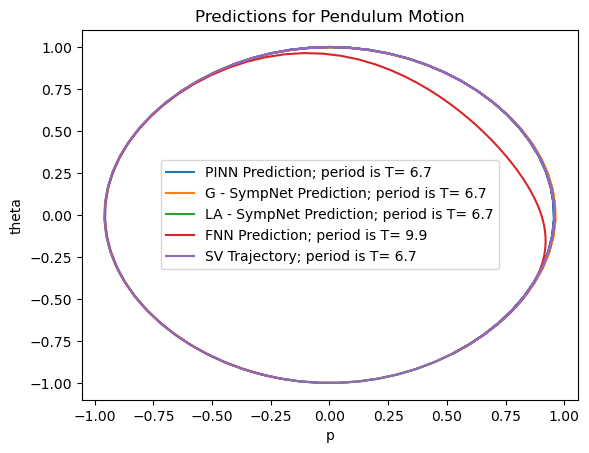

In [265]:
plt.plot(trajectory_PINN[:,0], trajectory_PINN[:,1], label='PINN Prediction; period is T= '+str(find_period(trajectory_PINN)))
plt.plot(trajectory_symp[:,0], trajectory_symp[:,1], label='G - SympNet Prediction; period is T= '+ str(find_period(trajectory_symp)))
plt.plot(trajectory_LA_symp[:,0], trajectory_LA_symp[:,1], label='LA - SympNet Prediction; period is T= '+ str(find_period(trajectory_LA_symp)))
plt.plot(trajectory[:,0], trajectory[:,1], label='FNN Prediction; period is T= '+ str(find_period(trajectory)))
plt.plot(y_test[:,0], y_test[:,1], label='SV Trajectory; period is T= '+ str(find_period(y_test)))
plt.xlabel('p')
plt.ylabel('theta')
plt.title('Predictions for Pendulum Motion')
plt.legend()
plt.savefig('phase_comparison.png')
plt.show()